## How to query, fetch, and store STAC Collections on a single node or multi-node with Dask

(wip)

Our goal is to provide a more full featured toolkit for querying, fetching, processing, and writing array datasets, including rasters. 

The data model should support satellite image time series with multiple coordinate reference systems distributed as COGs or multidimensional climate and weather data as NetCDF or Zarr. 

### We should be able to represent datacubes and sparse imagery collections with the same (family) of data models provided by Xarray

Xarray DataArrays - "N-dimensional array with labeled coordinates and dimensions." Or a thin wrapper around numpy arrays (or other arrays like cupy, dask, etc.)

Xarray Datasets - "A multi-dimensional, in memory, array database." The mapping interface with keys given by variable names and values given by DataArray objects for each variable name. (not a database in the literal sense)

A table of Xarray DataArrays or Datasets. Or Xarray Datatree? - each row refers to a datacube with a unique CRS or data in a single CRS if it is more efficient to handle sparsity in the data

??? what's a Datatree or table of Xarray objects?
A table of Xarray objects - Doesn't exist in an easy to use package.
Datatree - very recently added as the newest core data model. nodes are Xarray Datasets. can map operations across nodes or within specific nodes https://docs.xarray.dev/en/stable/generated/xarray.DataTree.html

### Why Xarray? Why not just numpy and torch tensors?
Some cool things you can do with Xarray and friends that are harder with pure numpy or rasterio

Parallelize data operations (IO, processing, model inference) on single node or multi-node on different compute backends (Dask is popular)

Access dataset variables by names that come directly from STAC metadata. no more being limited to positional indexes where the meaning changes from dataset to dataset and is hard to interpret.

```python
ndvi = (cropped.red - cropped.green) / (cropped.red + cropped.green)
```

Xarray variables can be concatenated together if they are the same dimensions. You can easily transpose with dimension labels as well, which leads to more readable code. 

```python
rgb = xr.concat(
        [cropped.red, cropped.green, cropped.blue],
        dim="channel"
    ).transpose("time", "channel", "y", "x")
```

positional indexing is readily available with `isel`. `.sel` allows for label based indexing similar to pandas. plotting is simple and auto annotates the plot with correct coordinates

```python
sampled_ds.red.isel(time=1, x=slice(10000, 11024), y=slice(10000, 11024))
```

So how do the above data models relate to Earth Observation data?

#### Neat multidimensional datacube, a Dataset or DataArray
<img src="https://miro.medium.com/v2/resize:fit:1400/1*_sLx6JtLdaZxyCYbbjgTPQ.png" width="500">

Datacubes like these are typically distributed in NetCDF, HDF, or (increasingly common) Zarr (or Kerchunk/VirtualiZarr, which turn NetCDF/HDF into Zarr)

```python
import xarray

ds = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)
ar_full_37_1h = ds.sel(time=slice("2024-01-01", "2024-12-31"]))
```

#### Sparse global satellite imagery.


<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs00521-020-05449-7/MediaObjects/521_2020_5449_Fig2_HTML.png" width="400" height="200">

Satellite imagery is messier. Instead of distributing data in one data store like a .zarr, we need to use multiple files to encode scene specific georeferencing and visualization data. But we can still fetch STAC queries and work with these in Xarray with `odc.stac` one library in the Open Data Cube family of libs. 

An example of fetching STAC items from a previous query as an Xarray Dataset.

```python
ds = odc.stac.load(
    items,
    bands = ['red', 'green', 'blue', 'nir', 'temperature'],
    groupby='solar_day'
)
```

I want to understand if we can use odc.stac to performantly fetch sparsely distributed satellite imagery across complex AOIs. For a realisitc scenario, the below notebook walks through how to query, fetch, and save COGs for Sentinel-2 3 band 3 timestep time series. These COGs can later be loaded as inputs for model inference with the SATLAS marine infrastructure model.

1. construct an area of interest representing coastal buffers around a few countries
2. Divide that area of interest by a UTM grid and intersect each grid with the coastal AOI to form mini-AOIs
3. Submit a STAC query for each mini-AOI, get STAC items (metadata)
4. Prune the STAC Items returned such that we only take the minimum amount of STAC items to cover each mini-AOI
5. fetch STAC Items in parallel with ODC STAC, which uses Dask, Xaray, and rasterio under the hood, get an xarray Dataset (lazy data)
6. Plot the results, check that we did the right thing
7. Save the results to COGs.

That's a lot of steps! Ideally we would only need to run one odc.stac.load call and get one datacube. However we need to minimize reprojection for performance and accuracy and datacube sparsity for performance reasons (OOM). So let's get to it.

### Step 1. Connect to Dask Cluster

In [1]:
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.

### Step 2. Import dependencies 

These are for querying, fetching, grouping and stacking rasters, and saving with dask

In [2]:
from datetime import datetime, timedelta
import stacrs
import pystac_client
from shapely.geometry import Point
import xarray as xr
import pyproj
import geopandas as gpd

import odc
import odc.geo.xr
from odc.stac import configure_rio, stac_load
from odc.geo.geobox import GeoBox, GeoboxTiles, Geometry
from odc.geo.gridspec import GridSpec

### Step 3. Set up the AOI geometry

This step can be fairly involved depending on the complexity of the datasets involved and the query parameters. In our case, we need to monitor coastal areas for offshore wind development. We also need to divide this global coastal aoi into different UTM regions. Doing this was easier in Wherobots, geopandas was slow joining these relatively simple geometries.

See [coast_aois.ipynb](./coast_aois.ipynb)

In [3]:
coastal_aoi = gpd.read_file("coast_aois.geojson").union_all()
coastal_geom = Geometry(coastal_aoi, crs = 4326) # odc.geo for tiling functionality
# coastal_geom.explore()

In [4]:
utm_grid = gpd.read_file("../utm-mgrs-ups-grid/utm-zone-boundaries/UTM_Zone_Boundaries.shp")

In [5]:
from pyproj import CRS
import pandas as pd

def get_epsg(zones, hemispheres):
    """
    Gets EPSG codes for UTM zones and hemispheres.

    Args:
        zones (pandas.Series): UTM zones.
        hemispheres (pandas.Series): Hemispheres ('N' or 'S').

    Returns:
        pandas.Series: EPSG codes or None if not found.
    """
    epsg_codes = []
    for zone, hemi in zip(zones, hemispheres):
        crs = CRS.from_dict({'proj': 'utm', 'zone': zone, 'south': hemi.lower() == 's'})
        try:
            epsg = crs.to_epsg()
            epsg_codes.append(epsg)
        except AttributeError:
            epsg_codes.append(None) 
        except RuntimeError:
            epsg_codes.append(None)

    return pd.Series(epsg_codes) # Return as pandas Series


utm_grid['epsg'] = get_epsg(utm_grid['ZONE'], utm_grid['HEMISPHERE'])

In [6]:
utm_grid[['epsg', 'geometry']].to_parquet('utm_zones.parquet')

To get the exact areas of interest (coastlines of countries with wind farms) we need to write some code that calculates a 75 kilometer distance away from coastlines so that we only run inference on scenes where there could be wind farms.

I ran the spatial join between the UTM grid and the coastal AOIs on wherobots for speed. then download the result with geometries and epsg codes for coastal aois separated by utm zones. This results in about 26 unique UTM zones across Australia, China, Netherlands, etc. See [coast_aois.ipynb](./coast_aois.ipynb)

In [7]:
coastal_utm_aois = gpd.read_file("coastal_aois_with_utm.parquet")

### Step 4. Set up STAC query across collection id, space, time, bands, quality

In [8]:
def convert_to_iso_datetime_range(simple_date_range):
    start_date_str, end_date_str = simple_date_range.split('/')
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    start_date_iso = start_date.strftime("%Y-%m-%dT%H:%M:%S.%fZ")[:-3] + "Z"
    end_date_iso = (end_date - timedelta(seconds=1)).strftime("%Y-%m-%dT%H:%M:%S.%fZ")[:-3] + "Z"
    return f"{start_date_iso}/{end_date_iso}"

In [9]:
# filtering STAC items
max_cloud_cover = 5
max_nodata_percent = 5
query_params = {
            "eo:cloud_cover": {"lt": max_cloud_cover},
            "s2:nodata_pixel_percentage": {"lt": max_nodata_percent},
        }
# because the coverage ratio is only 75% when data is collected for a whole year, increasing range to two years.
# this iteration in making the search query is a common workflow and involves checking the coverage ratio and date distribution of scenes
# to ensure that the coverage is spatially and temporally full in the right places. Commonly done visually/manually.

# sometimes though, there won't be enough coverage. in these cases, user needs to be made aware that not enough coverage can be acheived due
# either to spatial gaps and/or temporal gaps. for example, adding the year 2022 does not help coverage for example utm zone.
simple_date_range = "2023-01-01/2023-12-31"
iso_datetime_range = convert_to_iso_datetime_range(simple_date_range)
collection_id = "sentinel-2-c1-l2a"
catalog = "https://earth-search.aws.element84.com/v1"
# we still need to calculate the spatial area of interest

# processing variables post query
tile_size = 1024,1024
time_steps = 3
time_aggregation_unit = "month"
time_aggregation_range = 6 # we take 3 observations within a 6 month period

# stacking args
assets=["red", "blue", "green"]
rescale=False
xy_coords="center"
stack_id = "grid:code"
stack_dim = "time"

### Creating a grid that only intersects our multipolygon coastal AOI

We want to:

* Lazily load STAC Items as DataArrays
* Only reproject if needed, lazily
* control the compositing order of multiple scenes in a time series
* Keep the UTM projection of each STAC Item or the closest projection if we mosaic multiple scenes with odc.stac.load

With our grid we will submit multiple STAC queries, one for each UTM grid cell in parallel.

The result will be many datacubes, one for each UTM grid cell. From these we can sample tiles, save as COG with ODC and preserve the local projection which we will need for georeferencing the result and to preserve area of each pixel.

### 4.1. Generate GridSpecs

Each UTM gets an associated grid of 1024x1024 pixel samples we will save as COGs.

In [10]:
coastal_utm_aois['grid_spec'] = coastal_utm_aois.apply(lambda row: GridSpec(crs=row['epsg'], 
                                                                tile_shape=(1024, 1024), 
                                                                resolution=10), axis=1)

### 4.2 Calculate the tiles within each UTM AOI's GridSpec

Each tile in a given grid spec represents a spatial footprint that needs to be populated with a stacked time series of raster bands. This stack of rasters is then saved as a COG and is passed to a model later.

In [13]:
coastal_utm_aois['tiles'] = coastal_utm_aois.apply(lambda row: 
                                                   list(row['grid_spec'].tiles_from_geopolygon(
                                                       geopolygon=Geometry(row['geometry'], 
                                                        4326))), axis=1)

In [14]:
print("Tiles for each Coastal UTM AOI\n", coastal_utm_aois['tiles'].apply(len))
print("Total Tiles", coastal_utm_aois['tiles'].apply(len).sum())

Tiles for each Coastal UTM AOI
 0      697
1     1566
2     1348
3     1261
4     1918
5     1844
6     2336
7     1525
8      605
9      278
10    1408
11    1161
12      53
13     765
14    1209
15    1062
16    1889
17     168
18      86
19     782
20     759
21    1234
22    1835
23     318
24     339
25     279
26     114
Name: tiles, dtype: int64
Total Tiles 26839


One of our samples off the coast of Australia

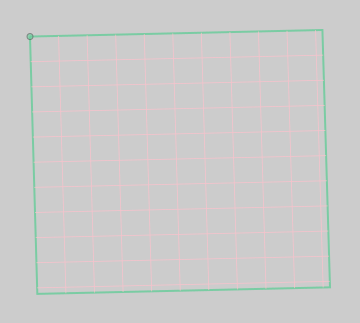

In [15]:
coastal_utm_aois.tiles[0][0][1]

### Step 5: Make the STAC Query and fetch the items with odc.stac

Now that we have our grid_spec, tiles, and coastal_aois we have a few different options for how we fetch the data. Each method comes with different trade-offs and are suitable for different scenarios.

**Different Scenarios**

Wide Area of Interest, Sparsely Distributed, many to many CRSs
* multiple polygons or multiple multipolygons describe where we want to fetch imagery.
* We don't want to fetch data over areas we don't care about. Maybe our focus is land, deep ocean, coastal areas, forests, etc.
* at each AOI, we may be fetching multiple scenes that share projections or come with different projections. we need to reproject scenes onto a common grid for each UTM zone
* requires multiple odc.stac queries, one for each intersection between an AOI and UTM zone.

Wide Area of Interest, Little sparsity, result is a mosaic with single CRS
* the AOI can be described by a polygon or a simple multi polygon
* We don't mind fetching some data over areas we don't care about, because it's a drop in the bucket compared to useful data we fetch
* the data may already be in a global projection. if not, we need to choose to do lots of reprojection or fetch in the original projection.
* one odc.stac query. or odc.stac not needed if collection is in Zarr or VirtualiZarr format, Xarray open.mfdataset can be used directly.

Limited Area of Interest, one datacube, one CRS
* in this case we can fetch all the data we need easily without reprojection, though there may be resampling needed to align onto a common grid (Planet Labs Planetscope)
* one odc.stac query


To illustrate what happens if we simply try to fetch all the data for our coastal areas taken as one geometry we'll use one odc.stac call on the geometry and look at the estimated size fo the output array. **not what you should do in this case but feels natural** a common stumbling block with odc.stac and stackstac

In [14]:
catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")
search = catalog.search(
    collections=[collection_id],
    intersects=coastal_aoi,
    datetime=iso_datetime_range,
    query=query_params,
    max_items=20
)

In [15]:
%%time
items = list(search.item_collection())

CPU times: user 34.2 ms, sys: 11.5 ms, total: 45.7 ms
Wall time: 917 ms


STAC Item contains the metadata info for a scene. A good number of python libraries can interpret and use these pystac objects, odc.stac is one of them.

Below we use odc stac to union together scenes take across the world into a single Xarray Dataset. This dataset is very sparse and coordinates are not lazy, so it is massive and takes a long time, abotu 2 minutes.

Instead, we should only materialize data when it is accessed for computation, ideally in chunks so that memory does not explode. We also need a way to determine if chunks are empty and ignore them.

In [17]:
%%time
ds = odc.stac.load(
    items,
    groupby='solar_day',
    chunks={'time': 1, 'x': 1024, 'y': 1024},
    use_overviews=False,
    max_items=20
)

CPU times: user 2min 10s, sys: 4.78 s, total: 2min 15s
Wall time: 2min 15s


The coordinates alone are .02 Gb. Lazy flexible coordinates will address this and resolve accuracy issues related to finite limits on floating point precision when roundtripping to/from Zarr. 

https://github.com/pydata/xarray/pull/9543
https://discourse.pangeo.io/t/example-which-highlights-the-limitations-of-netcdf-style-coordinates-for-large-geospatial-rasters/4140/40

The array is massive, and xarray will quickly error if you try to fetch 5 terabytes of data

In [18]:
ds.red

<xarray.DataArray 'red' (time: 2, y: 1878822, x: 368095)> Size: 3TB
dask.array<red, shape=(2, 1878822, 368095), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 15MB 2.514e+07 2.514e+07 ... 6.349e+06 6.349e+06
  * x            (x) float64 3MB -2.871e+06 -2.871e+06 ... 8.097e+05 8.098e+05
    spatial_ref  int32 4B 32753
  * time         (time) datetime64[ns] 16B 2023-12-30T01:46:17.498000 2023-12...
Attributes:
    nodata:   0

The error below is expected since we are requesting too much data. Sparse array support is still very green in Xarray, so blocks that are all nodata get materialized.

In [42]:
ds.x*ds.y

MemoryError: Unable to allocate 5.03 TiB for an array with shape (368095, 1878822) and data type float64

Instead, we need to construct a STAC query for each UTM Grid area. Then save out the 1024x1024 tiles from those as COGs.

### Step 5: Constructing the actual queries, for each UTM AOI individually

In [16]:
crs = CRS.from_epsg(coastal_utm_aois['epsg'][0])
utm_geom = Geometry(coastal_utm_aois['geometry'][0], crs=4326) # source coords are in wgs84 for query

In [23]:
iso_datetime_range = '2023-01-01T00:00:00.0000Z/2024-12-31T23:59:59.0000Z'
query_params = {'eo:cloud_cover': {'lt': 5}}

In [24]:
catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")
search = catalog.search(
    collections=[collection_id],
    intersects=utm_geom,
    datetime=iso_datetime_range,
    query=query_params,
    max_items=None
)
items = list(search.item_collection())

In [22]:
len(items)

2057

### Step 5.2: Greedily find the max coverage of the AOI out of the STAC Items returned before odc.stac.load

1. add a geom to the geom list, check coverage
2. if coverage of unary union of geom list is less than max coverage, check for the first geom that is closest to the date of previous geom
3. repeat step 1. if coverage is above or at max coverage, or if there are no more geoms, finish and report the coverage ratio to max coverage

This max coverage function whittles down all the STAC items from our query above to the minimum needed to maximize spatial coverage.

This can be run for each time period of interest to prune a larger list of STAC items if uniform sampling through time that maximizes spatial coverage at each time range is desired.

In [25]:
from datetime import datetime, timezone
from dateutil.parser import parse
from collections import OrderedDict
from odc.geo.geom import unary_union, Geometry

def max_coverage_geom_list(items, aoi_geom, max_coverage_threshold=0.95):
    """
    Finds a list of geometries that maximizes AOI coverage with the minimal number of items.

    This is done in a greedy fashion by adding new items if they add to the coverage. Selectively
    adds the next item if it is close in date to the previous item. Prioritizes assembling a mosaic from
    scenes close together in time. So this function is best run for each time range of interest.

    Args:
        items: List of STAC Item objects, each with 'geometry' and 'datetime'.
        aoi_geom: The Area of Interest (AOI) as a shapely geometry.
        max_coverage_threshold: The desired coverage ratio.

    Returns:
        A tuple containing:
        - A list of selected geometries (or None if no suitable geometries found or input is empty).
        - The achieved coverage ratio.
    """

    if not items:
        return None, 0.0
    
    items_by_date = OrderedDict(sorted([(item.datetime, item) for item in items]))

    selected_geoms = []
    selected_items = []
    aoi_area = aoi_geom.area
    coverage_ratio = 0.0

    while items_by_date and coverage_ratio < max_coverage_threshold:
        current_dt, current_item = items_by_date.popitem(last=False) 

        geom = Geometry(current_item.geometry, crs=4326).to_crs(aoi_geom.crs)
        selected_geoms.append(geom)
        selected_items.append(current_item)

        unioned_geom = unary_union(selected_geoms)
        coverage_area = unioned_geom.intersection(aoi_geom).area
        coverage_ratio = coverage_area / aoi_area

        if coverage_ratio >= max_coverage_threshold:
            break
            
        if coverage_ratio < max_coverage_threshold and items_by_date:
            closest_date = min(items_by_date, key=lambda dt: abs(dt - current_dt))
            closest_item = items_by_date.pop(closest_date)

            closest_geom = Geometry(closest_item.geometry, crs=4326).to_crs(aoi_geom.crs)
            selected_geoms.append(closest_geom)
            selected_items.append(closest_item)
            
            unioned_geom = unary_union(selected_geoms)
            coverage_area = unioned_geom.intersection(aoi_geom).area
            coverage_ratio = coverage_area / aoi_area

    return selected_geoms, selected_items, coverage_ratio

In [26]:
aoi_geom = utm_geom.to_crs(crs)

In [27]:
selected_geoms, selected_items, coverage_ratio = max_coverage_geom_list(items, aoi_geom, max_coverage_threshold=1)

In [28]:
len(selected_items)==len(items)

False

By pruning STAC items to only include what gets us to full spatial coverage, we only fetch 46 scenes instead of 2057.

In [29]:
len(items)

2057

In [30]:
len(selected_items)

46

In [31]:
coverage_ratio

1.0

For this AOI we are able to get full coverage with 46 STAC Items spread across 2 weeks in January 2023.

In [37]:
selected_items[0::6]

[<Item id=S2A_T49JGL_20230102T024320_L2A>,
 <Item id=S2B_T49JGH_20230104T023247_L2A>,
 <Item id=S2B_T49JFN_20230107T024319_L2A>,
 <Item id=S2A_T49JGM_20230109T023248_L2A>,
 <Item id=S2A_T49JGJ_20230109T023248_L2A>,
 <Item id=S2A_T49KGR_20230112T024319_L2A>,
 <Item id=S2A_T49JFN_20230112T024319_L2A>,
 <Item id=S2B_T49JGN_20230114T023245_L2A>]

In [133]:
import folium

mymap = folium.Map()

In [134]:
aoi_geom.explore(mymap) # the aoi

In [135]:
odc.geo.geom.multigeom(selected_geoms).explore(mymap) #aoi with our STAC footprints

In [26]:
coverage_ratio

1.0

### Step 5.3. (Finally!) Fetching an Xarray that triggers data fetching when computed

Some params for fetching and stacking need some explaining

`groupby='solar_day'` merges overlapping scenes that occur on the same solar day even if they are taken at different times within that day. This is useful so that we don't have a very deep time stack and lots of nodata gaps for each time slice. we want wall to wall spatial coverage at each time slice.

`chunks={'x': 1024, 'y': 1024}` sets the unit of parallelism that will be fetched and processed. Dask handles this. The term `chunk` is used to mean `partition` by Xarray, Dask, zarr-python and other array-oriented libraries.

`bands` are the sattelite bands we want to fetch. We don't need to speciy these here since xarray will refer to any bands lazily, but it saves us from specifying these later.

In [151]:
%%time
ds = odc.stac.load(
    selected_items,
    bands = assets,
    groupby='solar_day',
    chunks={'time': 1, 'x': 1024, 'y': 1024},
    use_overviews=False,
    crs=crs,
    geopolygon=aoi_geom
)

CPU times: user 381 ms, sys: 0 ns, total: 381 ms
Wall time: 377 ms


In [152]:
ds.red

<xarray.DataArray 'red' (time: 6, y: 86923, x: 14489)> Size: 15GB
dask.array<red, shape=(6, 86923, 14489), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 695kB 7.659e+06 7.659e+06 ... 6.79e+06 6.79e+06
  * x            (x) float64 116kB 6.667e+05 6.667e+05 ... 8.116e+05 8.116e+05
    spatial_ref  int32 4B 32749
  * time         (time) datetime64[ns] 48B 2023-01-02T02:45:09.869000 ... 202...
Attributes:
    nodata:   0

### Plotting an example and saving everything to COG

In [153]:
import os
os.environ["AWS_NO_SIGN_REQUEST"] = "YES"

In [154]:
aoi_geom.crs

CRS('EPSG:32749')

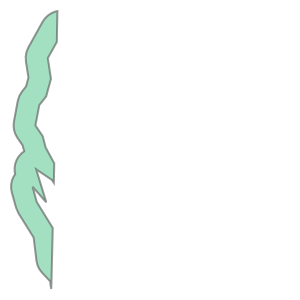

In [155]:
aoi_geom

In [157]:
cropped = odc.geo.xr.crop(ds, aoi_geom, apply_mask=False, all_touched=False)

In [158]:
cropped

<xarray.Dataset> Size: 45GB
Dimensions:      (y: 86923, x: 14489, time: 6)
Coordinates:
  * y            (y) float64 695kB 7.659e+06 7.659e+06 ... 6.79e+06 6.79e+06
  * x            (x) float64 116kB 6.667e+05 6.667e+05 ... 8.116e+05 8.116e+05
    spatial_ref  int32 4B 32749
  * time         (time) datetime64[ns] 48B 2023-01-02T02:45:09.869000 ... 202...
Data variables:
    red          (time, y, x) uint16 15GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    blue         (time, y, x) uint16 15GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 15GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

## ISSUE the cropped arrays are much too big, by a rough factor of 8

(14400, 7500) should be the size of the cropped array since that's where we have data. But nodata values take up most of the array.

In [145]:
ds

<xarray.Dataset> Size: 113GB
Dimensions:      (y: 101500, x: 30978, time: 6)
Coordinates:
  * y            (y) float64 812kB 7.7e+06 7.7e+06 ... 6.685e+06 6.685e+06
  * x            (x) float64 248kB 6e+05 6e+05 6e+05 ... 9.098e+05 9.098e+05
    spatial_ref  int32 4B 32749
  * time         (time) datetime64[ns] 48B 2023-01-02T02:45:09.869000 ... 202...
Data variables:
    red          (time, y, x) uint16 38GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    blue         (time, y, x) uint16 38GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 38GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [146]:
cropped

<xarray.Dataset> Size: 45GB
Dimensions:      (y: 86923, x: 14489, time: 6)
Coordinates:
  * y            (y) float64 695kB 7.659e+06 7.659e+06 ... 6.79e+06 6.79e+06
  * x            (x) float64 116kB 6.667e+05 6.667e+05 ... 8.116e+05 8.116e+05
    spatial_ref  int32 4B 32749
  * time         (time) datetime64[ns] 48B 2023-01-02T02:45:09.869000 ... 202...
Data variables:
    red          (time, y, x) uint16 15GB dask.array<chunksize=(1, 1018, 497), meta=np.ndarray>
    blue         (time, y, x) uint16 15GB dask.array<chunksize=(1, 1018, 497), meta=np.ndarray>
    green        (time, y, x) uint16 15GB dask.array<chunksize=(1, 1018, 497), meta=np.ndarray>

By cropping we remove extra pixels at the scene edges that fall outside of the area of interest above. odc.geo let's us apply this crop lazily, see how much space we save, and inspect the size of the resulting array. 

We save about half the pixels by removing pixels at the edges so that we don't materialize pixels that complete the square in places we don't care about fetching. 14 Gb vs 35 Gb.

In [118]:
arr = cropped.red.isel(time=0).compute()

In [119]:
arr

<xarray.DataArray 'red' (y: 86923, x: 14489)> Size: 3GB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y            (y) float64 695kB 7.659e+06 7.659e+06 ... 6.79e+06 6.79e+06
  * x            (x) float64 116kB 6.667e+05 6.667e+05 ... 8.116e+05 8.116e+05
    spatial_ref  int32 4B 32749
    time         datetime64[ns] 8B 2023-01-02T02:45:09.869000
Attributes:
    nodata:   0

In [115]:
arr

<xarray.DataArray 'red' (y: 86923, x: 14489)> Size: 3GB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y            (y) float64 695kB 7.659e+06 7.659e+06 ... 6.79e+06 6.79e+06
  * x            (x) float64 116kB 6.667e+05 6.667e+05 ... 8.116e+05 8.116e+05
    spatial_ref  int32 4B 32749
    time         datetime64[ns] 8B 2023-01-02T02:45:09.869000
Attributes:
    nodata:   0

In [144]:
arr.isel(x=slice(1000,8500), y=slice(55600, 70000)).shape

(14400, 7500)

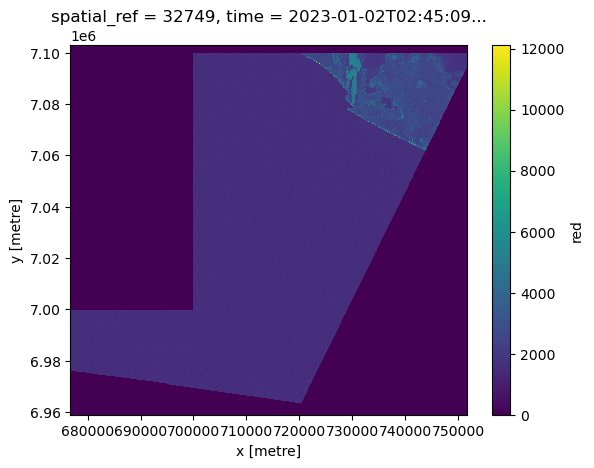

In [141]:
arr.isel(x=slice(1000,8500), y=slice(55600, 70000)).plot.imshow()

In [79]:
small_crop = cropped.red.isel(x=slice(1600,2000), y=slice(1500,2000), time=1).compute()

In [80]:
small_crop

<xarray.DataArray 'red' (y: 500, x: 400)> Size: 400kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y            (y) float64 4kB 7.644e+06 7.644e+06 ... 7.639e+06 7.639e+06
  * x            (x) float64 3kB 6.827e+05 6.827e+05 ... 6.867e+05 6.867e+05
    spatial_ref  int32 4B 32749
    time         datetime64[ns] 8B 2023-01-04T02:34:44.596000
Attributes:
    nodata:   0

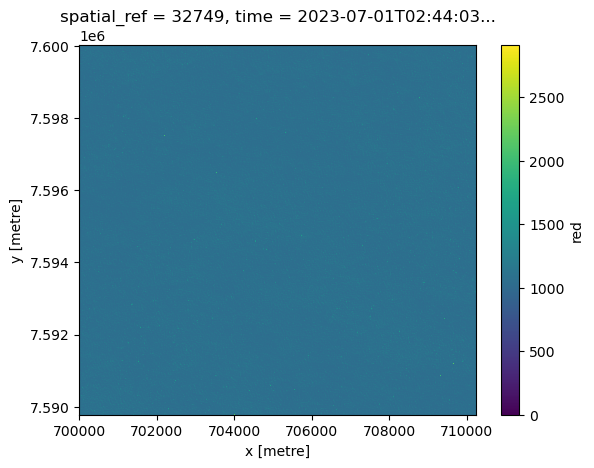

In [28]:
sampled_ds.red.isel(time=1, x=slice(10000, 11024), y=slice(10000, 11024)).plot.imshow()

Positional indexing for any dimension is dope

In [124]:
sampled_ds.red.sel(x=slice(788475, 798725), y=slice(6799365, 6789125)).isel(time=1)

<xarray.DataArray 'red' (y: 1025, x: 1026)> Size: 2MB
dask.array<getitem, shape=(1025, 1026), dtype=uint16, chunksize=(978, 609), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 8kB 6.799e+06 6.799e+06 ... 6.789e+06 6.789e+06
  * x            (x) float64 8kB 7.885e+05 7.885e+05 ... 7.987e+05 7.987e+05
    spatial_ref  int32 4B 32749
    time         datetime64[ns] 8B 2023-07-01T02:44:03.185000
Attributes:
    nodata:   0

Label based indexing for any dimension is dope

In [27]:
sampled_ds.red.sel(time="2023-04-04")

<xarray.DataArray 'red' (time: 1, y: 101500, x: 30978)> Size: 6GB
dask.array<getitem, shape=(1, 101500, 30978), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 812kB 7.7e+06 7.7e+06 ... 6.685e+06 6.685e+06
  * x            (x) float64 248kB 6e+05 6e+05 6e+05 ... 9.098e+05 9.098e+05
    spatial_ref  int32 4B 32749
  * time         (time) datetime64[ns] 8B 2023-04-04T02:35:00.394000
Attributes:
    nodata:   0

it's easy to crop

In [66]:
Geometry(coastal_utm_aois['geometry'][0], crs = 4326).explore()


In [69]:
geom = coastal_utm_aois.tiles[0][0][1]
geom.explore()

In [110]:
sampled_ds

<xarray.Dataset> Size: 57GB
Dimensions:      (y: 101500, x: 30978, time: 3)
Coordinates:
  * y            (y) float64 812kB 7.7e+06 7.7e+06 ... 6.685e+06 6.685e+06
  * x            (x) float64 248kB 6e+05 6e+05 6e+05 ... 9.098e+05 9.098e+05
    spatial_ref  int32 4B 32749
  * time         (time) datetime64[ns] 24B 2023-04-04T02:35:00.394000 ... 202...
Data variables:
    red          (time, y, x) uint16 19GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    blue         (time, y, x) uint16 19GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 19GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [119]:
cropped = odc.geo.xr.crop(sampled_ds, geom.geographic_extent, apply_mask=False, all_touched=False)
cropped.red.isel(time=1).y

<xarray.DataArray 'y' (y: 1025)> Size: 8kB
array([6799365., 6799355., 6799345., ..., 6789145., 6789135., 6789125.])
Coordinates:
  * y            (y) float64 8kB 6.799e+06 6.799e+06 ... 6.789e+06 6.789e+06
    spatial_ref  int32 4B 32749
    time         datetime64[ns] 8B 2023-07-01T02:44:03.185000
Attributes:
    units:       metre
    resolution:  -10.0
    crs:         EPSG:32749

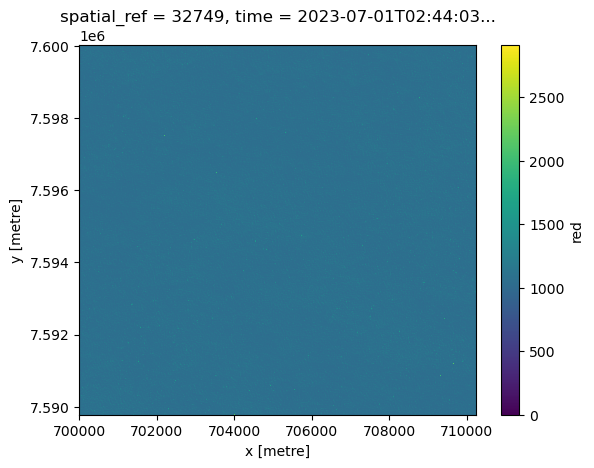

In [48]:
sampled_ds.red.isel(time=1, x=slice(10000, 11024), y=slice(10000, 11024)).plot.imshow()

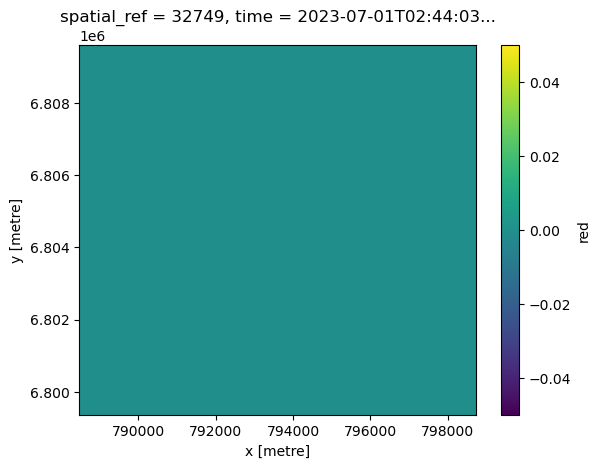

In [45]:
cropped.red.isel(time=1).plot.imshow()

It's very easy to make an rgb time series or any other band combination relative to RS_ functions

In [37]:
rgb = xr.concat(
        [cropped.red, cropped.green, cropped.blue],
        dim="channel"
    ).transpose("time", "channel", "y", "x")
rgb
rgb.isel(time=1, channel=1)

<xarray.DataArray 'red' (y: 1025, x: 1026)> Size: 2MB
dask.array<getitem, shape=(1025, 1026), dtype=uint16, chunksize=(978, 609), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 8kB 6.799e+06 6.799e+06 ... 6.789e+06 6.789e+06
  * x            (x) float64 8kB 7.885e+05 7.885e+05 ... 7.987e+05 7.987e+05
    spatial_ref  int32 4B 32749
    time         datetime64[ns] 8B 2023-07-01T02:44:03.185000
Attributes:
    nodata:   0

As shown above, computing features for the whole datacube is dead simple

In [40]:
(cropped.red - cropped.green) / (cropped.red + cropped.green)

<xarray.DataArray (time: 3, y: 1025, x: 1026)> Size: 25MB
dask.array<truediv, shape=(3, 1025, 1026), dtype=float64, chunksize=(1, 978, 609), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 8kB 6.799e+06 6.799e+06 ... 6.789e+06 6.789e+06
  * x            (x) float64 8kB 7.885e+05 7.885e+05 ... 7.987e+05 7.987e+05
    spatial_ref  int32 4B 32749
  * time         (time) datetime64[ns] 24B 2023-04-04T02:35:00.394000 ... 202...

In [81]:
# sampled_ds.red.isel(time=1, y=slice(100000,101024), x=slice(100000,101024)).plot.imshow()